In [1]:
from utils import sars2_genome_info, add_syn_mut_attribute, add_mut_accumulation_attr, add_mut_at_node_attr
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats, DateToStr
from utils_randomization import get_total_muts_on_tree, get_branch_lengths, randomize_mutations_on_tree_multinomial
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import requests
import json
import math
import os

## Figure 1 follow up: Correlation between accumulation of S1 nonsynonymous mutations with clade success over time


Plot of correlation coefficient r between logistic growth rate and number of S1 subsitutions over time.

Compute p-value for some time points by comparing empirical data to 1000 randomized trees, where the position of each observed S1 mutation is assigned to a random branch by multinomial draw.


Get information about genome position and length of each gene 

In [2]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

In [3]:
regions_to_consider = [('S1', 's1_accumulation', 'S1', 'nonsyn')]


In [3]:
regions_to_consider = [('RdRp_synonymous', 'rdrp_syn_accumulation', 'RdRp', 'syn')]

Save jsons with the number of mutations and branch lengths, which will be used to run randomizations (with Snakefile in analysis/)

In [5]:
def save_tree_info_for_randomizations(build_dates):
    
    for build_date in build_dates:

        #read in tree
        tree_url = f'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_{build_date}.json'
        tree_json = requests.get(tree_url).json()
        #Put tree in Bio.Phylo format
        tree = json_to_tree(tree_json)

        # add information about synonymous mutations as an attribute of nodes of the tree
        tree = add_syn_mut_attribute(tree)

        #Add the number of mutations that occur at a node as an attribute of that node, for all nodes on the tree
        tree = add_mut_at_node_attr(tree)

        # Find the total number of mutations that occur within each gene on internal branches of the tree
        total_mutations_nonsyn, total_mutations_syn = get_total_muts_on_tree(tree)


        # find the length of all branches
        branch_names_all, branch_lengths_all = get_branch_lengths(tree)

        branch_info_to_export = {"names":branch_names_all, "lengths":branch_lengths_all}

        with open(f'randomization_results/{build_date}/branch_info_{build_date}.json', 'w') as outfile:
                json.dump(branch_info_to_export, outfile)

        mutation_counts_to_export = {"nonsyn":total_mutations_nonsyn, "syn":total_mutations_syn}

        with open(f'randomization_results/{build_date}/mutation_counts_{build_date}.json', 'w') as outfile:
                json.dump(mutation_counts_to_export, outfile)

In [6]:
save_tree_info_for_randomizations(['2021-01-15','2021-03-15', '2021-07-15', '2021-09-15'])

In [6]:
save_tree_info_for_randomizations(['2021-05-15'])

For each date specified, find the correlation between S1 mut accumulation and clade growth

In [54]:
def assign_tree_attributes(build_dates):
    
    # store information across all time points
    muts_information = []
    
    for build_date in build_dates:
        #read in tree
        tree_url = f'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_{build_date}.json'
        tree_json = requests.get(tree_url).json()
        #Put tree in Bio.Phylo format
        tree = json_to_tree(tree_json)
        
        # add information about synonymous mutations as an attribute of nodes of the tree
        tree = add_syn_mut_attribute(tree)
        
        #Add an attribute to each node that gives the total number of mutations 
        # (synonymous SNPs, or nonsynonymous SNPs plus deletions) accumulated 
        # between the tree root and that node (including mutations on the node)
        tree = add_mut_accumulation_attr(tree)

        # only look at internal nodes
        for node in tree.find_clades(terminal=False):


            # only nodes within 6 weeks of build end date have logisitic growth rates
            logistic_growth = None
            if "logistic_growth" in node.node_attrs:
                logistic_growth = node.node_attrs["logistic_growth"]["value"]

            if hasattr(node, "node_attrs"):
                # get inferred node date
                date = node.node_attrs["num_date"]["value"]

                # get emerging lineage assignment of node 
                if 'emerging_lineage' in node.node_attrs:
                    emerging_lineage = node.node_attrs['emerging_lineage']['value']
                    emerging_lineage = convert_linege_names(emerging_lineage)

                # make tidy df for seaborn plotting
                for r in regions_to_consider:
                    # there are no synonymous deletions, but S1 deletions will be stored with S1_syn mut information-> these will not be plotted
                    muts_information.append({'clade': node.name, 'date': date, 'build_date': build_date,
                                             'emerging_lineage': emerging_lineage,
                                             'mut_location': r[0], 
                                             'num_muts': node.node_attrs[r[1]],  
                                             'muts_per_codon': node.node_attrs[r[1]]/gene_lengths_aa[r[2]],
                                             'logistic_growth': logistic_growth})
                    
    # make list into dataframe
    muts_information_df = pd.DataFrame(muts_information)
    
    
    return muts_information_df   
        

In [60]:
muts_information_df = assign_tree_attributes(['2020-11-15','2020-12-15','2021-01-15', 
                                              '2021-02-15', '2021-03-15', '2021-04-15', 
                                              '2021-05-15', '2021-06-15', '2021-07-15', 
                                              '2021-08-15', '2021-09-15', '2021-10-15', 
                                              '2021-11-15'])

Save the results of correlation between logistic growth rate and mutation accumulation over time, for each gene

In [58]:
# export r value for each gene and each time point
def save_correlation_results(build_dates):
    
    for r in regions_to_consider:
        # check if results file already exists for this gene
        results_json = f'r_over-time_results/{r[0]}_correlation_over-time.json'
        
        # open file if it already exists and check which dates have already been run
        if os.path.exists(results_json):
            with open(results_json) as json_file:
                results_already_saved = json.load(json_file)
                
                dates_already_saved = [d['build_date'] for d in results_already_saved['correlation_over_time']]
                
                for b in build_dates:
                    if b in dates_already_saved:
                        pass
                    # add results to file if that build_date isn't already included
                    else:
                        
                        subset_df = muts_information_df[muts_information_df['build_date']==b]
                        slope, r_value = get_linear_reg_stats(subset_df, r[0], 'logistic_growth', 'muts_per_codon')
                        results_already_saved['correlation_over_time'].append({'build_date': b, 'gene': r[2], 
                                                                    'nonsyn_syn': r[3], 'r_value':r_value})
                
                # save results file with new build_dates added
                with open(f'r_over-time_results/{r[0]}_correlation_over-time.json', 'w') as outfile:
                    json.dump(results_already_saved, outfile)
                
                
        # if there is no results file for this gene, make one
        else:

            r_values_to_export = {'correlation_over_time':[]}
            
            for b in build_dates:
                subset_df = muts_information_df[muts_information_df['build_date']==b]
                slope, r_value = get_linear_reg_stats(subset_df, r[0], 'logistic_growth', 'muts_per_codon')
                results_already_saved['correlation_over_time'].append({'build_date': b, 'gene': r[2], 
                                                            'nonsyn_syn': r[3], 'r_value':r_value})

            with open(f'r_over-time_results/{r[0]}_correlation_over-time.json', 'w') as outfile:
                json.dump(r_values_to_export, outfile)

In [61]:
save_correlation_results(['2020-11-15','2020-12-15','2021-01-15', 
               '2021-02-15', '2021-03-15', '2021-04-15', 
               '2021-05-15', '2021-06-15', '2021-07-15', 
               '2021-08-15', '2021-09-01', '2021-09-15', 
               '2021-10-01', '2021-10-15', '2021-11-01',
               '2021-11-15'])


In [94]:
def plot_r_over_time(build_dates, filename=None):
    """
    For S1, plot the correlation coefficient r 
    (between logistic growth rate and number of mutations per codon) over time
    """
    
    
    # read in empirical r values over time
    empirical_r_datafile = 'r_over-time_results/s1_correlation_over-time.json'
    
    with open(empirical_r_datafile) as json_file:
        data = json.load(json_file)
        to_plot = pd.DataFrame(data['correlation_over_time'])

    # limit plotting to only the dates specified
    to_plot = to_plot[to_plot['build_date'].isin(build_dates)]
    to_plot['build_date'] = pd.Categorical(to_plot['build_date'],
                                   categories=build_dates,
                                   ordered=True)

    # initialize figure format
    fig, ax= plt.subplots(figsize=(12,3))
    plt.tight_layout()
    sns.set_style('white')
    
    # plot r over time as a line with each gene as a different color
    ax = sns.lineplot(x='build_date', y='r_value', data = to_plot, 
                      color= '#4770eb', linewidth=4)


    ax.tick_params(axis='y', which='major', labelsize=12)
    
    ax.set_ylabel('$r$', fontsize = 18)
    ax.set_xlabel('Build date', fontsize = 14)
    
    ax.tick_params(axis='x', which='major', labelsize=12, rotation=30)
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    
    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    

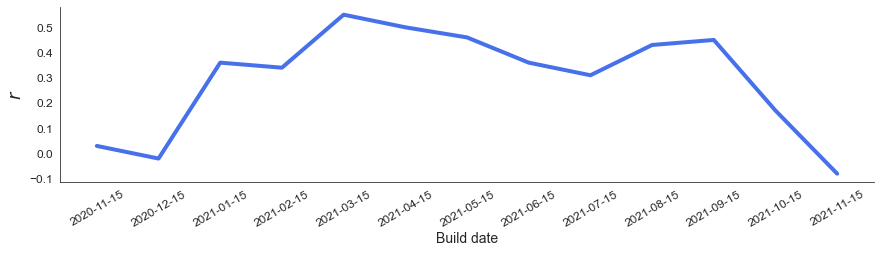

In [95]:
plot_r_over_time(['2020-11-15','2020-12-15','2021-01-15', 
               '2021-02-15', '2021-03-15', '2021-04-15', 
               '2021-05-15', '2021-06-15', '2021-07-15', 
               '2021-08-15', '2021-09-15', '2021-10-15', 
               '2021-11-15'], filename='plots/r_overtime_a.png')

Get p-value for each gene by comparing empirical correlation coefficient to randomizations

In [45]:
def get_randomized_rvalues(build_date):
    
    # primary build randomizations are stored in a different location
    if build_date == '2021-05-15':
        # files storing primary build randomizations
        data_files = ['randomization_results/growth_rate_stats/growth_stats_50it.json', 
            'randomization_results/growth_rate_stats/growth_stats_50itmore.json', 
            'randomization_results/growth_rate_stats/growth_stats_200its.json', 
            'randomization_results/growth_rate_stats/growth_stats_400its.json', 
            'randomization_results/growth_rate_stats/growth_stats_300its.json']
        
        # initialize dataframe to store information from all .json files where data is stored
        to_plot = pd.DataFrame(columns = ['data', 'iteration', 'gene', 'nonsyn_syn', 'r_value'])

        # read in all randomization R values
        for data_file in data_files:
            with open(data_file) as json_file:
                data = json.load(json_file)
                df = pd.DataFrame(data['growth_rate_stats'])
                to_plot = pd.concat([to_plot, df])
                
        r_values = list(to_plot[(to_plot['gene']=='S1') & (to_plot['nonsyn_syn']=='nonsyn')]['r_value'])
        
        
    else:

        path = f'randomization_results/{build_date}/randomizations/S1/'
        randomization_files = [path+f for f in listdir(path) if isfile(join(path, f))]

        to_plot = pd.DataFrame(columns = ["data","iteration","gene","nonsyn_syn","r_value"])

        for data_file in randomization_files:
            with open(data_file) as json_file:
                data = json.load(json_file)
                index = int(data['iteration'])
                df = pd.DataFrame(data, index=[index])
                to_plot = pd.concat([to_plot, df])

        r_values = list(to_plot['r_value'])
            
    return r_values

For 5 dates, centered around 05-15, plot S1 mut accumulation versus clade growth. Show linear regression, r value and p-value based on comparison with randomizations

In [80]:
# add column to color lineages as is done in manuscript for the primary analysis
manuscript_lineage_map = {'basal': 'basal',
 'A.23.1': 'other VOI',
 'B.1.351 (Beta)': 'Beta',
 'B.1.526 (Iota)': 'other VOI',
 'B.1.621': 'other VOI',
 'B.1.427/429 (Epsilon)': 'other VOI',
 'B.1.620': 'other VOI',
 'B.1.617.1 (Kappa)': 'other VOI',
 'B.1.617.2 (Delta)': 'Delta',
 'B.1.619': 'other VOI',
 'B.1.525 (Eta)': 'other VOI',
 'B.1.1.7 (Alpha)': 'Alpha',
 'P.1 (Gamma)': 'Gamma',
 'C.36.3': 'other VOI',
 'C.37 (Lambda)': 'other VOI',
 'B.1.1.519': 'other VOI',
 'B.1.1.318': 'other VOI'}

muts_information_df['manuscript_lineage'] = muts_information_df['emerging_lineage'].map(manuscript_lineage_map)

In [97]:
def plot_fig1_timeseries(build_dates, filename=None):
    

    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}


    
    # initialize figure format
    fig, axes= plt.subplots(int(math.ceil(len(build_dates)/5)),5, figsize=(12,3), sharey=True, sharex=True)
    plt.tight_layout()
    sns.set_style('white')
    
    for i, ax in enumerate(axes.flat):
        
        if i< len(build_dates):
            build_date = build_dates[i]

            subset_df = muts_information_df[muts_information_df['build_date']== build_date]

            ax = sns.scatterplot(x='logistic_growth', y="muts_per_codon", hue= 'manuscript_lineage',
                  hue_order= list(cmap.keys()), palette=cmap,
                  data = subset_df[subset_df['mut_location']=='S1'], 
                  ax=ax, legend=False)
            sns.regplot(x='logistic_growth', y="muts_per_codon", scatter=False, ax=ax, 
                        data = subset_df[subset_df['mut_location']=='S1'], 
                        line_kws={"color":'black'}, ci=95)

            ax.set_xlabel("Logistic Growth Rate", fontsize = 14)
            ax.set_title(f'{build_date}', fontsize = 16, fontweight='bold')

            # run linear regression on the plot
            slope, r_value = get_linear_reg_stats(subset_df, 'S1', 'logistic_growth', 'muts_per_codon')
            
            # get p-value
            randomized_r_values = get_randomized_rvalues(build_date)

            pvalue= len([element for element in randomized_r_values if element > r_value])/len(randomized_r_values)
            if pvalue < 0.001:
                pvalue = '< 0.001'
            else:
                pvalue = round(pvalue, 3)

            ax.annotate(f'$r$: {r_value} \np-value: {pvalue}', xy=(-20,0.028), size=14, va='top', ha='left')


            ax.set_ylim(-0.0025,0.030)
            ax.set_xlim(-24, 15)
            plt.setp(ax.get_xticklabels(), fontsize=12)
            plt.setp(ax.get_yticklabels(), fontsize=12)


        
        

        
    # label y axis of the outer subplots
    for i, ax in enumerate(axes.flat):
        if i==0:
            ax.set_ylabel('S1 substitutions\n per codon', fontsize = 14)


    # remove box around plot
    sns.despine(left=False, bottom=False)
    # adjust spacing between plots
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    


    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

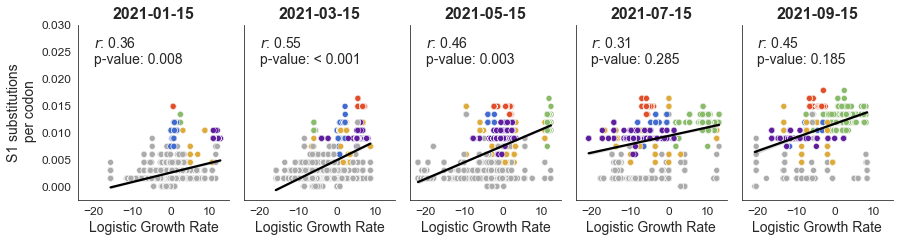

In [98]:
plot_fig1_timeseries(['2021-01-15', '2021-03-15',  
                      '2021-05-15', '2021-07-15', '2021-09-15'], filename='plots/r_overtime_b.png')